In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

class cifar10vgg:
    def __init__(self,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('cifar10vgg.h5')
        return model

if __name__ == '__main__':


    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    model = cifar10vgg()

    predicted_x = model.predict(x_test)
    residuals = np.argmax(predicted_x,1)!=np.argmax(y_test,1)

    loss = sum(residuals)/len(residuals)
    print("the validation 0/1 loss is: ",loss)

Using TensorFlow backend.
W1001 05:32:41.316672  4364 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 05:32:41.330636  4364 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 05:32:41.332629  4364 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1001 05:32:41.354569  4364 deprecation_wrapper.py:119] From c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get

Epoch 1/250
 - 44s - loss: 21.2232 - acc: 0.1986 - val_loss: 22.9403 - val_acc: 0.0955
Epoch 2/250
 - 41s - loss: 11.4616 - acc: 0.2693 - val_loss: 9.3095 - val_acc: 0.1141
Epoch 3/250
 - 39s - loss: 9.2050 - acc: 0.2015 - val_loss: 8.4733 - val_acc: 0.1710
Epoch 4/250
 - 39s - loss: 6.7605 - acc: 0.2178 - val_loss: 5.3784 - val_acc: 0.2050
Epoch 5/250
 - 38s - loss: 4.3645 - acc: 0.2822 - val_loss: 3.5626 - val_acc: 0.2722
Epoch 6/250
 - 38s - loss: 2.9870 - acc: 0.3524 - val_loss: 3.2213 - val_acc: 0.2446
Epoch 7/250
 - 38s - loss: 2.2657 - acc: 0.4308 - val_loss: 2.2317 - val_acc: 0.3913
Epoch 8/250
 - 38s - loss: 1.8953 - acc: 0.4982 - val_loss: 1.9322 - val_acc: 0.4733
Epoch 9/250
 - 38s - loss: 1.6708 - acc: 0.5571 - val_loss: 1.6819 - val_acc: 0.5733
Epoch 10/250
 - 38s - loss: 1.5879 - acc: 0.5934 - val_loss: 1.4975 - val_acc: 0.6276
Epoch 11/250
 - 39s - loss: 1.5116 - acc: 0.6285 - val_loss: 1.5148 - val_acc: 0.6420
Epoch 12/250
 - 38s - loss: 1.4780 - acc: 0.6577 - val_loss:

Epoch 97/250
 - 38s - loss: 0.5671 - acc: 0.9186 - val_loss: 0.6151 - val_acc: 0.9059
Epoch 98/250
 - 38s - loss: 0.5646 - acc: 0.9181 - val_loss: 0.6221 - val_acc: 0.9000
Epoch 99/250
 - 38s - loss: 0.5602 - acc: 0.9192 - val_loss: 0.6287 - val_acc: 0.8994
Epoch 100/250
 - 38s - loss: 0.5646 - acc: 0.9178 - val_loss: 0.6332 - val_acc: 0.9009
Epoch 101/250
 - 38s - loss: 0.5256 - acc: 0.9287 - val_loss: 0.5725 - val_acc: 0.9147
Epoch 102/250
 - 38s - loss: 0.5067 - acc: 0.9341 - val_loss: 0.5795 - val_acc: 0.9143
Epoch 103/250
 - 38s - loss: 0.5018 - acc: 0.9340 - val_loss: 0.5660 - val_acc: 0.9192
Epoch 104/250
 - 38s - loss: 0.4879 - acc: 0.9380 - val_loss: 0.5556 - val_acc: 0.9198
Epoch 105/250
 - 38s - loss: 0.4819 - acc: 0.9388 - val_loss: 0.5806 - val_acc: 0.9130
Epoch 106/250
 - 39s - loss: 0.4727 - acc: 0.9405 - val_loss: 0.5741 - val_acc: 0.9128
Epoch 107/250
 - 38s - loss: 0.4751 - acc: 0.9392 - val_loss: 0.5738 - val_acc: 0.9124
Epoch 108/250
 - 38s - loss: 0.4672 - acc: 0.9

Epoch 192/250
 - 38s - loss: 0.2609 - acc: 0.9798 - val_loss: 0.4762 - val_acc: 0.9306
Epoch 193/250
 - 38s - loss: 0.2588 - acc: 0.9803 - val_loss: 0.4742 - val_acc: 0.9295
Epoch 194/250
 - 38s - loss: 0.2573 - acc: 0.9807 - val_loss: 0.4760 - val_acc: 0.9295
Epoch 195/250
 - 38s - loss: 0.2613 - acc: 0.9787 - val_loss: 0.4776 - val_acc: 0.9297
Epoch 196/250
 - 38s - loss: 0.2586 - acc: 0.9806 - val_loss: 0.4754 - val_acc: 0.9306
Epoch 197/250
 - 38s - loss: 0.2573 - acc: 0.9802 - val_loss: 0.4738 - val_acc: 0.9316
Epoch 198/250
 - 38s - loss: 0.2587 - acc: 0.9789 - val_loss: 0.4740 - val_acc: 0.9318
Epoch 199/250
 - 38s - loss: 0.2594 - acc: 0.9798 - val_loss: 0.4698 - val_acc: 0.9321
Epoch 200/250
 - 38s - loss: 0.2587 - acc: 0.9789 - val_loss: 0.4708 - val_acc: 0.9313
Epoch 201/250
 - 38s - loss: 0.2553 - acc: 0.9804 - val_loss: 0.4692 - val_acc: 0.9317
Epoch 202/250
 - 38s - loss: 0.2546 - acc: 0.9811 - val_loss: 0.4705 - val_acc: 0.9320
Epoch 203/250
 - 38s - loss: 0.2522 - acc: 

In [3]:
mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y)\
    = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [13]:
import numpy as np
def get_submax(arr):
    arr = np.array(arr)
    MAX = np.max(arr)
    idx = find_idx(arr, MAX)
    arr_without_max = np.delete(arr,idx)
    return np.max(arr_without_max)
def find_statistics(Prob_Mat):
    Prob_diff = []
    MAX_Prob_Mat = []
    MAX_Prob_Mat_idx = []
    subMAX_Prob_Mat = []
    subMAX_Prob_Mat_idx = []
    for i in range(len(Prob_Mat)):
        MAX = np.max(Prob_Mat[i])
        MAX_idx = find_idx(Prob_Mat[i], MAX)[0]
        subMAX = get_submax(Prob_Mat[i])
        subMAX_idx = find_idx(Prob_Mat[i], subMAX)[0]
        prob_difference = MAX - subMAX
        Prob_diff.append(prob_difference)
        MAX_Prob_Mat.append(MAX)
        subMAX_Prob_Mat.append(subMAX)
        MAX_Prob_Mat_idx.append(MAX_idx)
        subMAX_Prob_Mat_idx.append(subMAX_idx)
    return Prob_diff,MAX_Prob_Mat,MAX_Prob_Mat_idx,subMAX_Prob_Mat,subMAX_Prob_Mat_idx
import pandas as pd
def entropy_from_distribution(p, axis):
    return np.log(10.) + np.sum(p * np.log(np.abs(p) + 1e-11), axis=1, keepdims=True)
def conclusion_df(statistics, entropy):
    d = {'Prob_diff': statistics[0], 'MAX_Prob_Mat': statistics[1], 'MAX_Prob_Mat_idx': statistics[2], 'subMAX_Prob_Mat': statistics[3], 'subMAX_Prob_Mat_idx': statistics[4], 'entropy':entropy}
    df = pd.DataFrame(data=d)
    return df
def plot_avg_dist(Prob_Mat):
    plt.figure(figsize=(18, 12))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.hist(Prob_Mat[:,i], bins=20)
        plt.title('Prob_dist' + str(i))
    plt.show()
    return
def find_idx(arr, target):
    ans = []
    for i in range(len(arr)):
        if arr[i] == target:
            ans.append(i)
    return ans
import matplotlib.pyplot as plt


In [6]:
import cv2
import imutils
from skimage import exposure
B= []
for i in range(len(mnist_train_x)):
    A = mnist_train_x[i]
    A = exposure.rescale_intensity(A, out_range=(0, 255))
    A = imutils.resize(A, width=32)
    B.append(A)
B = np.array(B)

mnist_train_RGB_x = np.repeat(B[:,:, :, np.newaxis], 3, axis=3)
predicted_on_MNIST = model.predict(mnist_train_RGB_x)

In [7]:
predicted_on_CIFAR = predicted_x

In [11]:
statistics_ID = find_statistics(predicted_on_CIFAR)
statistics_OD = find_statistics(predicted_on_MNIST)
entropy_ID = entropy_from_distribution(predicted_on_CIFAR, axis=1)
entropy_ID = entropy_from_distribution(predicted_on_CIFAR, axis=1).reshape(entropy_ID.shape[0])

entropy_OD = entropy_from_distribution(predicted_on_MNIST, axis=1)
entropy_OD = entropy_from_distribution(predicted_on_MNIST, axis=1).reshape(entropy_OD.shape[0])
df_CIFAR_CIFAR, df_CIFAR_MNIST = conclusion_df(statistics_ID, entropy_ID), conclusion_df(statistics_OD, entropy_OD)

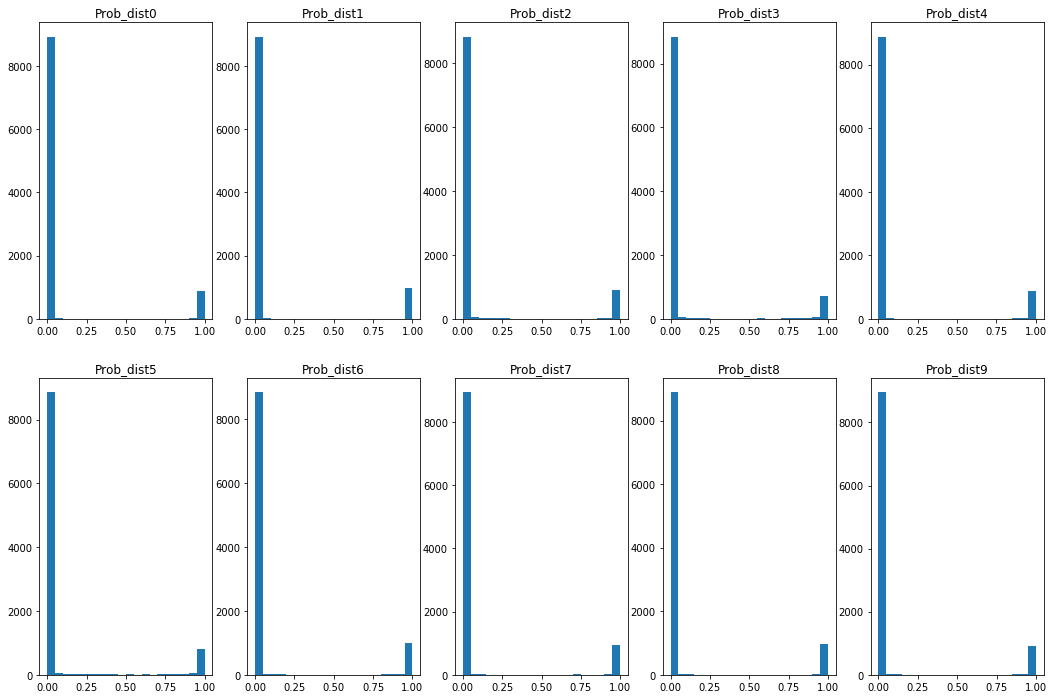

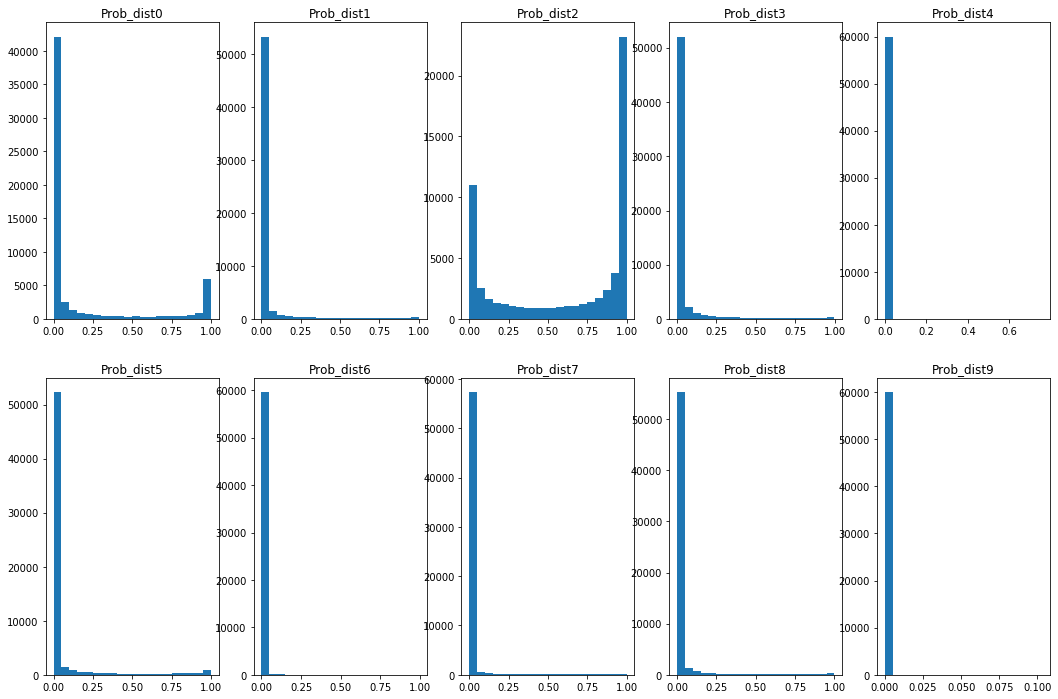

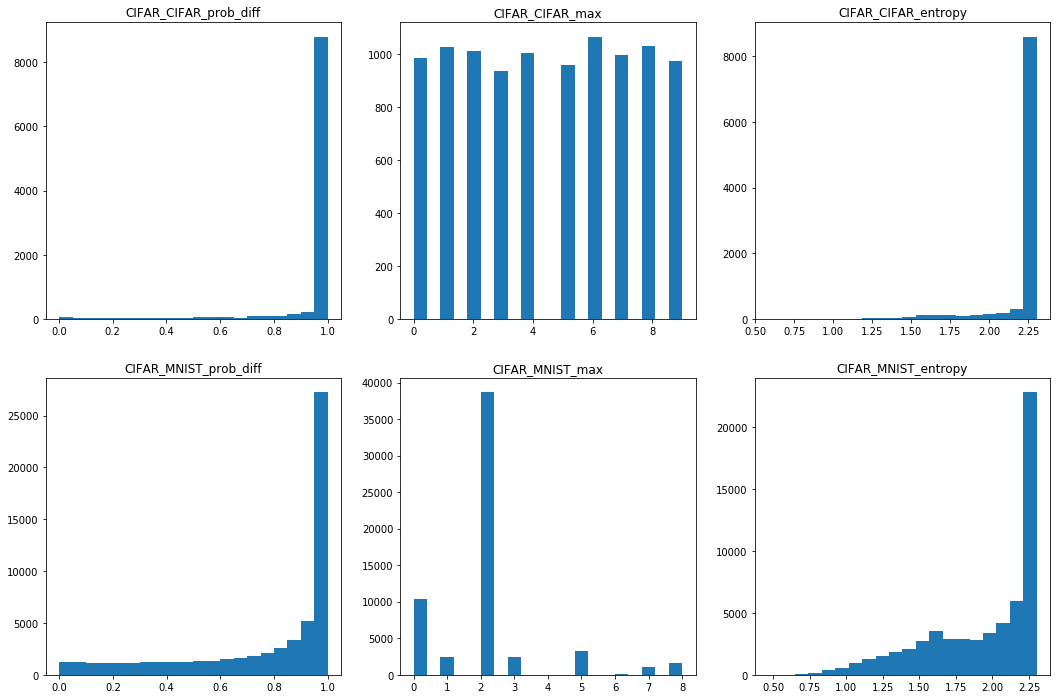

In [14]:
plot_avg_dist(predicted_on_CIFAR)
plot_avg_dist(predicted_on_MNIST)
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
plt.hist(df_CIFAR_CIFAR['Prob_diff'], bins=20)
plt.title('CIFAR_CIFAR_prob_diff')
plt.subplot(2, 3, 2)
plt.hist(df_CIFAR_CIFAR['MAX_Prob_Mat_idx'], bins=20)
plt.title('CIFAR_CIFAR_max')
plt.subplot(2, 3, 3)
plt.hist(df_CIFAR_CIFAR['entropy'], bins=20)
plt.title('CIFAR_CIFAR_entropy')
plt.subplot(2, 3, 4)
plt.hist(df_CIFAR_MNIST['Prob_diff'], bins=20)
plt.title('CIFAR_MNIST_prob_diff')
plt.subplot(2, 3, 5)
plt.hist(df_CIFAR_MNIST['MAX_Prob_Mat_idx'], bins=20)
plt.title('CIFAR_MNIST_max')
plt.subplot(2, 3, 6)
plt.hist(df_CIFAR_MNIST['entropy'], bins=20)
plt.title('CIFAR_MNIST_entropy')
plt.show()

In [15]:
predicted_on_MNIST

array([[4.2859480e-01, 1.2006214e-04, 5.6718755e-01, ..., 8.2144508e-04,
        1.0838737e-04, 3.3364145e-06],
       [6.0264359e-04, 5.1224437e-03, 8.6081380e-01, ..., 9.2744936e-05,
        1.4684601e-03, 2.1457283e-05],
       [9.9969864e-01, 3.1165171e-05, 2.0862297e-05, ..., 9.7323764e-06,
        7.8176336e-06, 1.2210580e-05],
       ...,
       [1.1099236e-04, 1.8454095e-05, 9.9925679e-01, ..., 4.9110917e-05,
        2.2424720e-05, 1.6298987e-06],
       [9.4449073e-01, 4.9118087e-02, 1.9527067e-03, ..., 1.2561266e-05,
        3.9477898e-03, 3.0664993e-05],
       [7.8644149e-02, 4.2826612e-03, 9.0168142e-01, ..., 3.8091376e-04,
        1.6122704e-04, 1.5230303e-05]], dtype=float32)

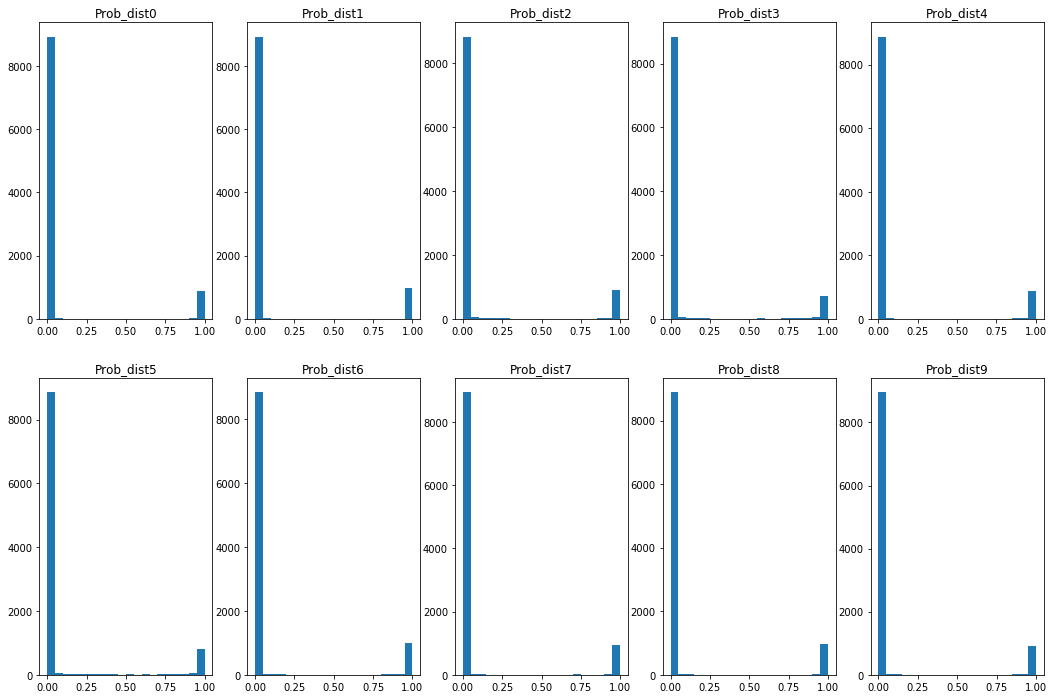

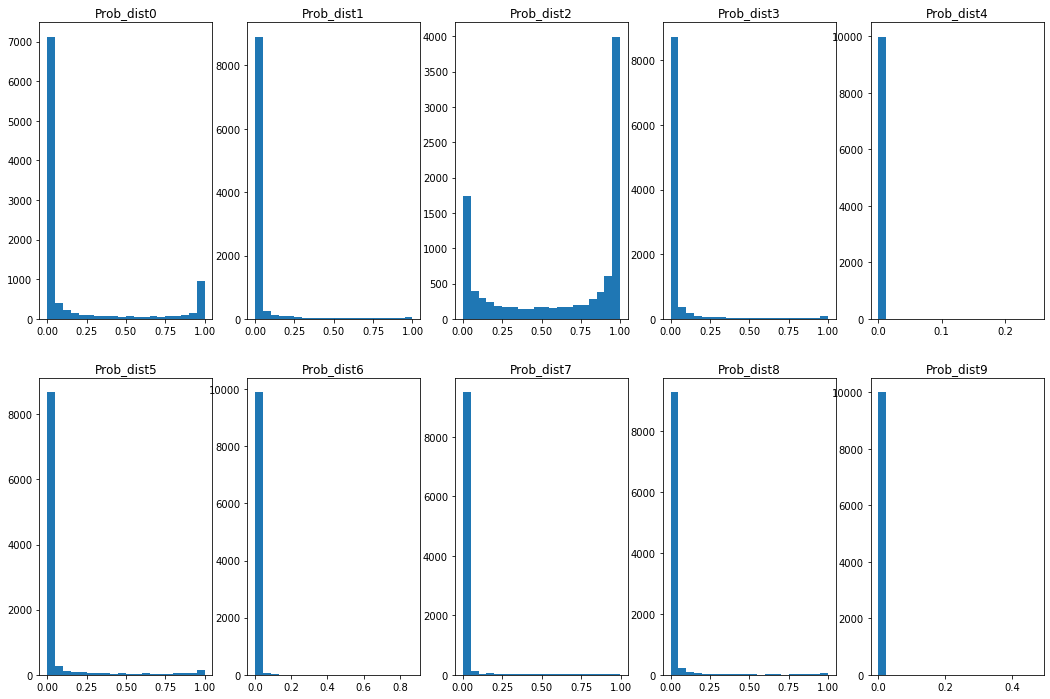

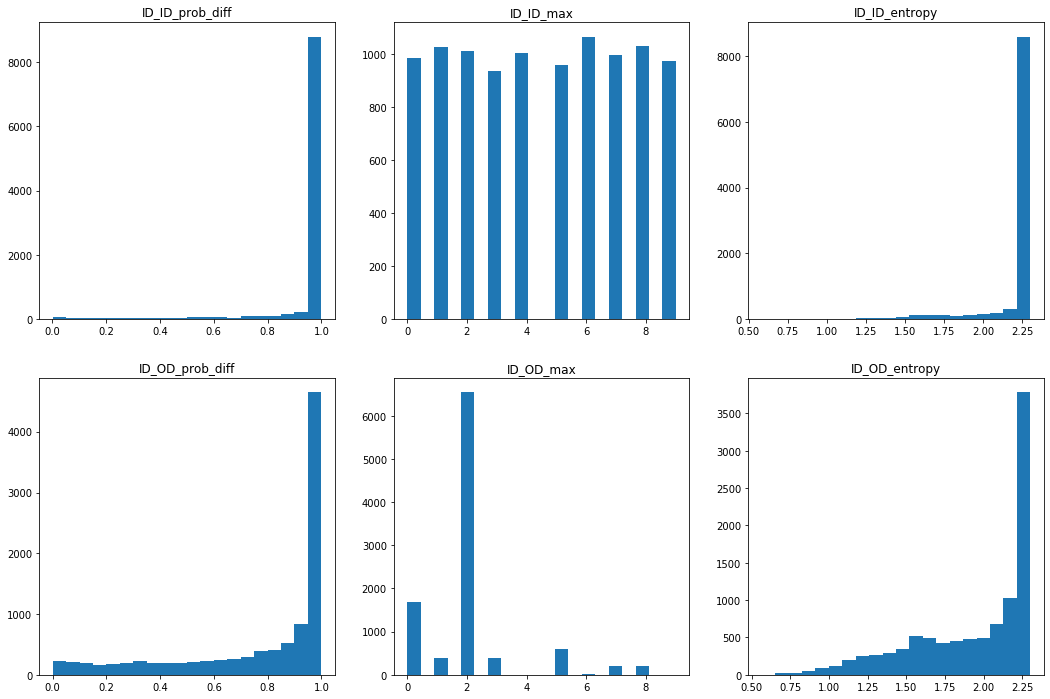

In [16]:
def report_ID_OD(predicted_ID, predicted_OD):

    statistics_ID = find_statistics(predicted_ID)
    statistics_OD = find_statistics(predicted_OD)
    entropy_ID = entropy_from_distribution(predicted_ID, axis=1)
    entropy_ID = entropy_from_distribution(predicted_ID, axis=1).reshape(entropy_ID.shape[0])

    entropy_OD = entropy_from_distribution(predicted_OD, axis=1)
    entropy_OD = entropy_from_distribution(predicted_OD, axis=1).reshape(entropy_OD.shape[0])
    df_ID_ID, df_ID_OD = conclusion_df(statistics_ID, entropy_ID), conclusion_df(statistics_OD, entropy_OD)

    plot_avg_dist(predicted_ID)
    plot_avg_dist(predicted_OD)
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 3, 1)
    plt.hist(df_ID_ID['Prob_diff'], bins=20)
    plt.title('ID_ID_prob_diff')
    plt.subplot(2, 3, 2)
    plt.hist(df_ID_ID['MAX_Prob_Mat_idx'], bins=20)
    plt.title('ID_ID_max')
    plt.subplot(2, 3, 3)
    plt.hist(df_ID_ID['entropy'], bins=20)
    plt.title('ID_ID_entropy')
    plt.subplot(2, 3, 4)
    plt.hist(df_ID_OD['Prob_diff'], bins=20)
    plt.title('ID_OD_prob_diff')
    plt.subplot(2, 3, 5)
    plt.hist(df_ID_OD['MAX_Prob_Mat_idx'], bins=20)
    plt.title('ID_OD_max')
    plt.subplot(2, 3, 6)
    plt.hist(df_ID_OD['entropy'], bins=20)
    plt.title('ID_OD_entropy')
    plt.show()
    
B= []
for i in range(len(mnist_test_x)):
    A = mnist_test_x[i]
    A = exposure.rescale_intensity(A, out_range=(0, 255))
    A = imutils.resize(A, width=32)
    B.append(A)
B = np.array(B)

mnist_test_RGB_x = np.repeat(B[:,:, :, np.newaxis], 3, axis=3)
predicted_on_MNIST2 = model.predict(mnist_test_RGB_x)
report_ID_OD(predicted_on_CIFAR, predicted_on_MNIST2)



In [17]:
model